## Первоначальный анализ данных и их обработка

### Установка библиотек

In [19]:
# Стандартные библиотеки
import ast
from pathlib import Path

# Научные вычисления и данные
import numpy as np
import pandas as pd
from numpy.linalg import norm

# Машинное обучение и обработка данных
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer

# Глубокое обучение (PyTorch)
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Визуализация
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Инструменты прогресса
from tqdm import tqdm


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

Using device: cuda


# Загрузка датасета
Здесь ничего не менял по сравнению с ноутбуком lab2.ipynb

In [3]:
# Загружаем основные файлы
df = pd.read_csv('dataset/data.csv')
df_genre = pd.read_csv('dataset/data_w_genres.csv')

# В data.csv артисты записаны как "['Artist1', 'Artist2']".
# Берем первого (основного) артиста для мэтчинга.
df['main_artist'] = df['artists'].apply(lambda x: ast.literal_eval(x)[0])

# Объединяем с данными о жанрах
df = pd.merge(df, df_genre[['artists', 'genres']], left_on='main_artist', right_on='artists', how='left')
df.drop('artists_y', axis=1, inplace=True)
df.rename(columns={'artists_x': 'artists'}, inplace=True)

# Заполняем пустые жанры заглушкой
df['genres'] = df['genres'].fillna("['unknown']")

In [4]:
df.columns

Index(['valence', 'year', 'acousticness', 'artists', 'danceability',
       'duration_ms', 'energy', 'explicit', 'id', 'instrumentalness', 'key',
       'liveness', 'loudness', 'mode', 'name', 'popularity', 'release_date',
       'speechiness', 'tempo', 'main_artist', 'genres'],
      dtype='object')

In [5]:
df.head(5)

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,...,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,main_artist,genres
0,0.0594,1921,0.982,"['Sergei Rachmaninoff', 'James Levine', 'Berli...",0.279,831667,0.211,0,4BJqT0PrAfrxzMOxytFOIz,0.878000,...,0.665,-20.096,1,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",4,1921,0.0366,80.954,Sergei Rachmaninoff,"['classical', 'post-romantic era', 'russian ro..."
1,0.9630,1921,0.732,['Dennis Day'],0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000000,...,0.160,-12.441,1,Clancy Lowered the Boom,5,1921,0.4150,60.936,Dennis Day,[]
2,0.0394,1921,0.961,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.328,500062,0.166,0,1o6I8BglA6ylDMrIELygv1,0.913000,...,0.101,-14.850,1,Gati Bali,5,1921,0.0339,110.339,KHP Kridhamardawa Karaton Ngayogyakarta Hadini...,[]
3,0.1650,1921,0.967,['Frank Parker'],0.275,210000,0.309,0,3ftBPsC5vPBKxYSee08FDH,0.000028,...,0.381,-9.316,1,Danny Boy,3,1921,0.0354,100.109,Frank Parker,[]
4,0.2530,1921,0.957,['Phil Regan'],0.418,166693,0.193,0,4d6HGyGT8e121BsdKmw9v6,0.000002,...,0.229,-10.096,1,When Irish Eyes Are Smiling,2,1921,0.0380,101.665,Phil Regan,[]


## Обучение нейросети и её настройка

Загрузка предобработанных данных

In [6]:
train_test_dir = Path("experimenter_folder/train_test_npy_and_metadata")
train_test_dir.mkdir(parents=True, exist_ok=True)

train_data_slice = 10000 # если нужно быстро проверить модель, то ставим меньшее число, например 10к

X_train_full = np.load(train_test_dir / "X_train.npy")[:train_data_slice]
X_test = np.load(train_test_dir / 'X_test.npy')

metadata_train_full = pd.read_csv(train_test_dir / "metadata_train.csv")[:train_data_slice]
metadata_test = pd.read_csv(train_test_dir / "metadata_test.csv")

print("Train shape:", X_train_full.shape)
print("Train playlists:", metadata_train_full['playlist_id'].nunique())
print("Test shape:", X_test.shape)
print("Test playlists:", metadata_test['playlist_id'].nunique())

Train shape: (10000, 9)
Train playlists: 2502
Test shape: (20385, 9)
Test playlists: 1019


In [7]:
unique_playlists = metadata_train_full['playlist_id'].unique()
train_pl, val_pl = train_test_split(
    unique_playlists, test_size=0.2, random_state=42
)

train_mask = metadata_train_full['playlist_id'].isin(train_pl)
val_mask = metadata_train_full['playlist_id'].isin(val_pl)

X_train = X_train_full[train_mask.values]
X_val = X_train_full[val_mask.values]

metadata_train = metadata_train_full[train_mask].reset_index(drop=True)
metadata_val = metadata_train_full[val_mask].reset_index(drop=True)

print("Train tracks:", len(X_train))
print("Val tracks:", len(X_val))
print("Val playlists:", metadata_val['playlist_id'].nunique())

Train tracks: 7970
Val tracks: 2030
Val playlists: 501


In [8]:
def cosine_similarity(a, b):
    return np.dot(a, b) / (norm(a) * norm(b) + 1e-8)


def recall_at_k(recommended, hidden, k):
    return len(set(recommended[:k]) & hidden) / len(hidden)


def ndcg_at_k(recommended, hidden, k):
    dcg = 0.0
    for i, idx in enumerate(recommended[:k]):
        if idx in hidden:
            dcg += 1 / np.log2(i + 2)

    ideal = sum(1 / np.log2(i + 2) for i in range(min(len(hidden), k)))
    return dcg / ideal if ideal > 0 else 0.0


def evaluate_playlist_continuation(df, K=10, hide_frac=0.3):
    recalls, ndcgs = [], []

    for pid, group in df.groupby('playlist_id'):
        if len(group) < 5:
            continue

        indices = group.index.to_numpy()
        np.random.shuffle(indices)

        split = int(len(indices) * (1 - hide_frac))
        known_idx = indices[:split]
        hidden_idx = indices[split:]

        known_z = np.vstack(df.loc[known_idx, 'z'])
        hidden = set(hidden_idx)

        playlist_vec = known_z.mean(axis=0)

        scores = []
        for idx, z in zip(df.index, df['z']):
            scores.append((idx, cosine_similarity(playlist_vec, z)))

        scores.sort(key=lambda x: x[1], reverse=True)
        recommended = [idx for idx, _ in scores if idx not in known_idx]

        recalls.append(recall_at_k(recommended, hidden, K))
        ndcgs.append(ndcg_at_k(recommended, hidden, K))

    return np.mean(recalls), np.mean(ndcgs)


def contrastive_playlist_loss(z, playlist_ids):
    loss = 0.0
    count = 0

    playlist_ids = np.array(playlist_ids)

    for pid in np.unique(playlist_ids):
        idx = np.where(playlist_ids == pid)[0]
        if len(idx) < 2:
            continue

        zi = z[idx]
        center = zi.mean(dim=0)
        loss += ((zi - center) ** 2).sum()
        count += len(idx)

    if count == 0:
        return torch.tensor(0.0, device=z.device)

    return loss / count

In [9]:
def evaluate_knn_baseline(df, X, K=10, hide_frac=0.3):
    df = df.copy()
    df['x'] = list(X)

    recalls, ndcgs = [], []

    for pid, group in df.groupby('playlist_id'):
        if len(group) < 5:
            continue

        indices = group.index.values
        np.random.shuffle(indices)

        split = int(len(indices) * (1 - hide_frac))
        known = indices[:split]
        hidden = set(indices[split:])

        playlist_vec = np.vstack(df.loc[known, 'x']).mean(axis=0)

        scores = []
        for idx, x in zip(df.index, df['x']):
            scores.append((idx, cosine_similarity(playlist_vec, x)))

        scores.sort(key=lambda x: x[1], reverse=True)
        recommended = [idx for idx, _ in scores if idx not in known]

        recalls.append(recall_at_k(recommended, hidden, K))
        ndcgs.append(ndcg_at_k(recommended, hidden, K))

    return np.mean(recalls), np.mean(ndcgs)


baseline_recall, baseline_ndcg = evaluate_knn_baseline(
    metadata_val.copy(),
    X_val.copy(),
    K=10
)

print(f"kNN baseline Recall@10: {baseline_recall:.4f}")
print(f"kNN baseline nDCG@10: {baseline_ndcg:.4f}")

kNN baseline Recall@10: 0.1331
kNN baseline nDCG@10: 0.0869


## Обогащение признаков:
Проведём простой эксперимент: попробуем подать модели на вход следующие признаки:'year', 'popularity', 'explicit', 'mode'

In [10]:
def prepare_enriched_features(X_orig, df_metadata):
    """
    Добавляет year, popularity, explicit, mode к исходным 9 признакам
    и масштабирует их в диапазон [0, 1]
    """
    extra_cols = ['year', 'popularity', 'explicit', 'mode']
    extra_data = df_metadata[extra_cols].values.astype(np.float32)
    
    # Масштабирование
    # Приводим к диапазону [0, 1]
    scaler_extra = MinMaxScaler()
    extra_data_scaled = scaler_extra.fit_transform(extra_data)
    
    # Склеиваем старые 9 признаков и 4 новых (итого 13)
    X_enriched = np.hstack([X_orig, extra_data_scaled])
    
    return X_enriched

# Создаем обогащенные наборы данных
X_train_enriched = prepare_enriched_features(X_train, metadata_train)
X_val_enriched = prepare_enriched_features(X_val, metadata_val)

print(f"Новая размерность признаков: {X_train_enriched.shape[1]}") # Должно быть 13

Новая размерность признаков: 13


In [11]:
class TracksWithPlaylistDataset(Dataset):
    def __init__(self, X, playlist_ids):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.playlist_ids = np.array(playlist_ids)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.playlist_ids[idx]

train_ds = TracksWithPlaylistDataset(
    X_train_enriched, 
    metadata_train['playlist_id'].values
)

train_loader = DataLoader(
    train_ds,
    batch_size=256,
    shuffle=True,
    drop_last=True
)

X_val_tensor = torch.tensor(X_val_enriched, dtype=torch.float32).to(device)

In [12]:
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, latent_dim=64):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            # nn.Dropout(0.15),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),

            nn.Linear(128, latent_dim)
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),

            nn.Linear(128, 256),
            nn.ReLU(),

            nn.Linear(256, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        z = nn.functional.normalize(z, dim=1)
        x_hat = self.decoder(z)
        return x_hat, z

In [13]:
model = AutoEncoder(input_dim=X_train_enriched.shape[1], latent_dim=11).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)
criterion = nn.MSELoss()


def total_loss(x, x_hat, z, playlist_ids):
    recon = criterion(x_hat, x)
    contrast = contrastive_playlist_loss(z, playlist_ids)
    return recon + lambda_contrast * contrast, recon, contrast


lambda_contrast = 0.2
num_epochs = 30

epoch_loss = []
epoch_recon = []
epoch_contrast = []
val_recalls = []
val_ndcgs = []

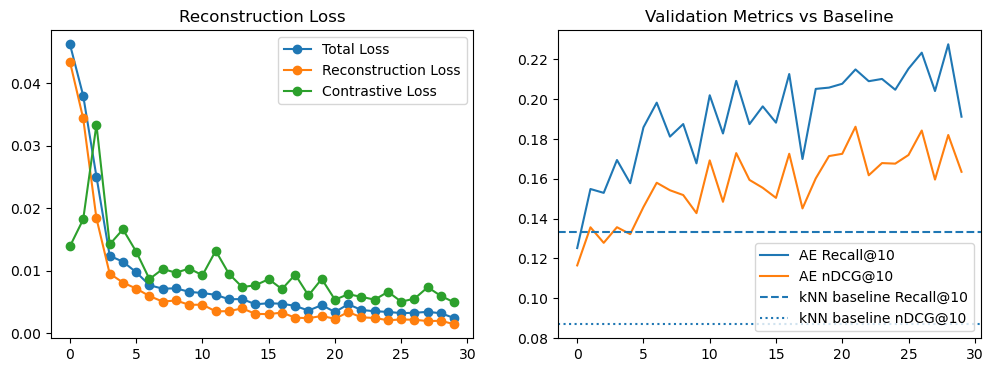

In [14]:
for epoch in range(num_epochs):
    # ===== TRAIN =====
    model.train()

    for x, pid in train_loader:
        x = x.to(device)
        noise = torch.randn_like(x) * 0.05
        optimizer.zero_grad()

        x_hat, z = model(x)
        loss, recon, contrast = total_loss(x, x_hat, z, pid)

        loss.backward()
        optimizer.step()

    epoch_loss.append(loss.item())
    epoch_recon.append(recon.item())
    epoch_contrast.append(contrast.item())

    # ===== VALIDATION METRIC =====
    model.eval()
    with torch.no_grad():
        Z_val = model.encoder(
            torch.tensor(X_val_enriched, device=device, dtype=torch.float32)
        ).cpu().numpy()

    metadata_val['z'] = list(Z_val)
    recall_k, ndcg_k = evaluate_playlist_continuation(metadata_val, K=10)
    scheduler.step(recall_k) # Sheduler

    val_recalls.append(recall_k)
    val_ndcgs.append(ndcg_k)

    # ===== VISUALIZATION =====
    clear_output(wait=False)

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    ax[0].plot(epoch_loss, label='Total Loss', marker='o')
    ax[0].plot(epoch_recon, label='Reconstruction Loss', marker='o')
    ax[0].plot(epoch_contrast, label='Contrastive Loss', marker='o')
    ax[0].set_title('Reconstruction Loss')
    ax[0].legend()

    ax[1].plot(val_recalls, label='AE Recall@10')
    ax[1].plot(val_ndcgs, label='AE nDCG@10')

    ax[1].axhline(
        baseline_recall,
        linestyle='--',
        label='kNN baseline Recall@10'
    )

    ax[1].axhline(
        baseline_ndcg,
        linestyle=':',
        label='kNN baseline nDCG@10'
    )

    ax[1].set_title('Validation Metrics vs Baseline')
    ax[1].legend()

    plt.show()

In [15]:
num_test_records = 5000 # чем больше, тем дольше работает

X_test_enriched = prepare_enriched_features(X_test, metadata_test)[:num_test_records]
print(f"Test enriched shape: {X_test_enriched.shape}")

Test enriched shape: (5000, 13)


In [16]:
# Считаем kNN Baseline на тестовых данных
test_baseline_recall, test_baseline_ndcg = evaluate_knn_baseline(
    metadata_test.copy()[:num_test_records], 
    X_test_enriched, 
    K=10
)

print(f"TEST BASELINE RESULTS")
print(f"kNN Baseline Recall@10: {test_baseline_recall:.4f}")
print(f"kNN Baseline nDCG@10:   {test_baseline_ndcg:.4f}")

TEST BASELINE RESULTS
kNN Baseline Recall@10: 0.1159
kNN Baseline nDCG@10:   0.1093


In [17]:
model.eval()

with torch.no_grad():
    # Получаем эмбеддинги Z для всего теста
    Z_test = model.encoder(
        torch.tensor(X_test_enriched[:num_test_records], device=device, dtype=torch.float32)
    ).cpu().numpy()

# Добавляем эмбеддинги в метаданные теста для оценки
metadata_test_eval = metadata_test.copy()[:num_test_records]
metadata_test_eval['z'] = list(Z_test)
# Считаем метрики модели
test_ae_recall, test_ae_ndcg = evaluate_playlist_continuation(metadata_test_eval, K=10)

print(f"TEST MODEL RESULTS")
print(f"AutoEncoder Recall@10: {test_ae_recall:.4f}")
print(f"AutoEncoder nDCG@10:   {test_ae_ndcg:.4f}")

# Считаем процент улучшения относительно бейзлайна
improvement = ((test_ae_recall - test_baseline_recall) / test_baseline_recall) * 100
print(f"\nУлучшение по Recall@10: {improvement:.2f}%")

TEST MODEL RESULTS
AutoEncoder Recall@10: 0.1720
AutoEncoder nDCG@10:   0.1541

Улучшение по Recall@10: 48.38%


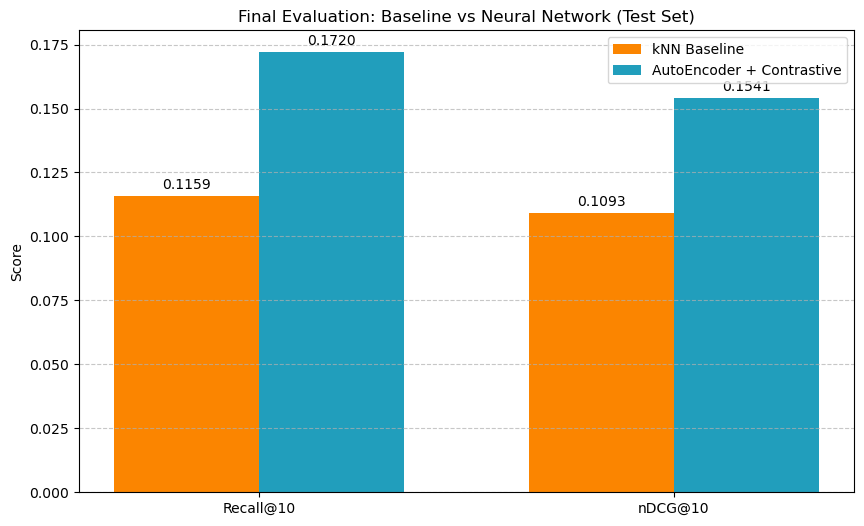

In [18]:
# Данные для графика
metrics = ['Recall@10', 'nDCG@10']
baseline_vals = [test_baseline_recall, test_baseline_ndcg]
model_vals = [test_ae_recall, test_ae_ndcg]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - width/2, baseline_vals, width, label='kNN Baseline', color='#fb8500')
rects2 = ax.bar(x + width/2, model_vals, width, label='AutoEncoder + Contrastive', color='#219ebc')

# Добавляем подписи и оформление
ax.set_ylabel('Score')
ax.set_title('Final Evaluation: Baseline vs Neural Network (Test Set)')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Добавляем значения над столбцами
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), 
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Результат на валидации выглядит лучше, чем в первой версии бейзлайна. Попробуем добавить ещё признаков
Примечание: в дальнейшем коде будет приведена сразу конечная версия данного улучшения

In [20]:
# pca для того, чтобы убрать кореллирующие или антикоррелирующие признаки
# Оставим 7 компонент, чтобы точно не потерять важные детали звука 
pca = PCA(n_components=7)
# Создадим отдельный скалер для выходов PCA
pca_scaler = MinMaxScaler()

# 1. Настройка SVD для жанров (выучим один раз на трейне)
tfidf = TfidfVectorizer(token_pattern=r"[a-zA-Z0-9\-']+")
svd_genres = TruncatedSVD(n_components=5) # Сожмем все жанры в 5 векторов

def get_circle_of_fifths_coords(keys):
    # Маппинг ключей в квинтовый круг: C=0, G=1, D=2...
    # (key * 7) % 12 — это математический переход по квинтам
    steps = (keys * 7) % 12
    angle = 2 * np.pi * steps / 12
    return np.sin(angle), np.cos(angle)

def prepare_smart_features(X_orig, df_metadata, is_train=True):
    # 1. PCA Audio
    if is_train:
        X_pca = pca.fit_transform(X_orig)
        X_pca_scaled = pca_scaler.fit_transform(X_pca)
    else:
        X_pca = pca.transform(X_orig)
        X_pca_scaled = pca_scaler.transform(X_pca)

    # 2. Умный Key (Circle of Fifths)
    k_sin, k_cos = get_circle_of_fifths_coords(df_metadata['key'].values)
    key_coords = np.column_stack([k_sin, k_cos]) # 2 колонки

    # 3. Умные Жанры (SVD)
    # Соединяем список жанров в одну строку "pop rock dance"
    genre_strings = df_metadata['genres'].apply(lambda x: " ".join(eval(x)) if isinstance(x, str) else "")
    if is_train:
        genre_tfidf = tfidf.fit_transform(genre_strings)
        genre_vectors = svd_genres.fit_transform(genre_tfidf)
    else:
        genre_tfidf = tfidf.transform(genre_strings)
        genre_vectors = svd_genres.transform(genre_tfidf)
    
    # Масштабируем жанры в [0, 1]
    gv_min, gv_max = genre_vectors.min(), genre_vectors.max()
    genre_vectors = (genre_vectors - gv_min) / (gv_max - gv_min + 1e-8)

    # 4. Стандартные признаки + Длительность
    extra_cols = ['year', 'popularity', 'explicit', 'mode']
    extra_data = df_metadata[extra_cols].values
    
    # Добавим логарифм длительности
    duration = np.log1p(df_metadata['duration_ms'].values).reshape(-1, 1)
    
    # Масштабируем всё вместе
    final_extra = np.hstack([extra_data, duration])
    scaler = MinMaxScaler()
    final_extra_scaled = scaler.fit_transform(final_extra)

    # ИТОГ: 7(PCA) + 2(Key) + 5(Genres) + 5(Extra) = 19 признаков
    X_final = np.hstack([X_pca_scaled, key_coords, genre_vectors, final_extra_scaled])
    
    return X_final.astype(np.float32)

# Применяем
X_train_smart = prepare_smart_features(X_train, metadata_train, is_train=True)
X_val_smart = prepare_smart_features(X_val, metadata_val, is_train=False)

print(f"Размерность: {X_train_smart.shape[1]}") # Ожидаем 19

Размерность: 19


In [21]:
train_ds = TracksWithPlaylistDataset(
    X_train_smart, 
    metadata_train['playlist_id'].values
)

train_loader = DataLoader(
    train_ds,
    batch_size=256,
    shuffle=True,
    drop_last=True
)

X_val_tensor = torch.tensor(X_val_smart, dtype=torch.float32).to(device)

In [22]:
model = AutoEncoder(input_dim=X_train_smart.shape[1], latent_dim=11).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max', 
    factor=0.5,
    patience=5,
)
criterion = nn.MSELoss()

lambda_contrast = 0.45
num_epochs = 30

epoch_loss = []
epoch_recon = []
epoch_contrast = []
val_recalls = []
val_ndcgs = []

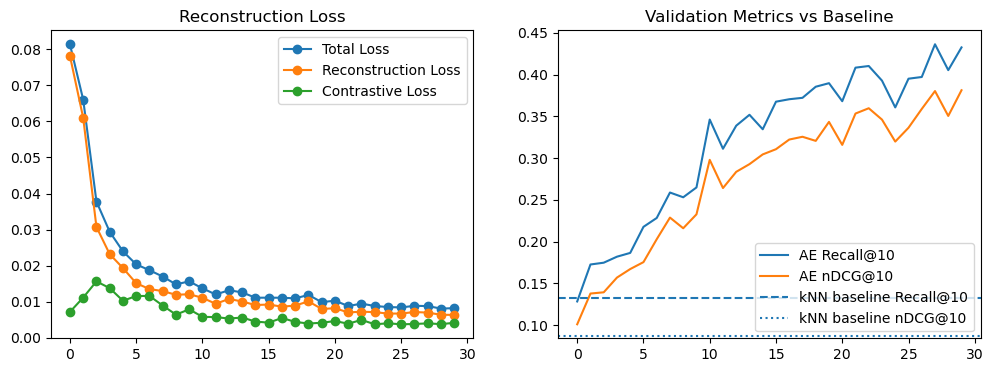

In [23]:
for epoch in range(num_epochs):
    # ===== TRAIN =====
    model.train()

    for x, pid in train_loader:
        x = x.to(device)
        noise = torch.randn_like(x) * 0.05
        optimizer.zero_grad()

        x_hat, z = model(x)
        loss, recon, contrast = total_loss(x, x_hat, z, pid)

        loss.backward()
        optimizer.step()

    epoch_loss.append(loss.item())
    epoch_recon.append(recon.item())
    epoch_contrast.append(contrast.item())

    # ===== VALIDATION METRIC =====
    model.eval()
    with torch.no_grad():
        Z_val = model.encoder(
            torch.tensor(X_val_smart, device=device, dtype=torch.float32)
        ).cpu().numpy()

    metadata_val['z'] = list(Z_val)
    recall_k, ndcg_k = evaluate_playlist_continuation(metadata_val, K=10)
    scheduler.step(recall_k) # Sheduler

    val_recalls.append(recall_k)
    val_ndcgs.append(ndcg_k)

    # ===== VISUALIZATION =====
    clear_output(wait=False)

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    ax[0].plot(epoch_loss, label='Total Loss', marker='o')
    ax[0].plot(epoch_recon, label='Reconstruction Loss', marker='o')
    ax[0].plot(epoch_contrast, label='Contrastive Loss', marker='o')
    ax[0].set_title('Reconstruction Loss')
    ax[0].legend()

    ax[1].plot(val_recalls, label='AE Recall@10')
    ax[1].plot(val_ndcgs, label='AE nDCG@10')

    ax[1].axhline(
        baseline_recall,
        linestyle='--',
        label='kNN baseline Recall@10'
    )

    ax[1].axhline(
        baseline_ndcg,
        linestyle=':',
        label='kNN baseline nDCG@10'
    )

    ax[1].set_title('Validation Metrics vs Baseline')
    ax[1].legend()

    plt.show()

In [24]:
X_test_smart = prepare_smart_features(X_test, metadata_test)[:num_test_records]
print(f"Test enriched shape: {X_test_smart.shape}")

Test enriched shape: (5000, 19)


In [25]:
test_baseline_recall, test_baseline_ndcg = evaluate_knn_baseline(
    metadata_test.copy()[:num_test_records], 
    X_test_smart, 
    K=10
)

print(f"TEST BASELINE RESULTS")
print(f"kNN Baseline Recall@10: {test_baseline_recall:.4f}")
print(f"kNN Baseline nDCG@10:   {test_baseline_ndcg:.4f}")

TEST BASELINE RESULTS
kNN Baseline Recall@10: 0.1005
kNN Baseline nDCG@10:   0.1053


In [26]:
model.eval()

with torch.no_grad():
    # Получаем эмбеддинги Z для всего теста
    Z_test = model.encoder(
        torch.tensor(X_test_smart[:num_test_records], device=device, dtype=torch.float32)
    ).cpu().numpy()

# Добавляем эмбеддинги в метаданные теста для оценки
metadata_test_eval = metadata_test.copy()[:num_test_records]
metadata_test_eval['z'] = list(Z_test)
# Считаем метрики модели
test_ae_recall, test_ae_ndcg = evaluate_playlist_continuation(metadata_test_eval, K=10)

print(f"TEST MODEL RESULTS")
print(f"AutoEncoder Recall@10: {test_ae_recall:.4f}")
print(f"AutoEncoder nDCG@10:   {test_ae_ndcg:.4f}")

# Считаем процент улучшения относительно бейзлайна
improvement = ((test_ae_recall - test_baseline_recall) / test_baseline_recall) * 100
print(f"\nУлучшение по Recall@10: {improvement:.2f}%")

TEST MODEL RESULTS
AutoEncoder Recall@10: 0.2424
AutoEncoder nDCG@10:   0.2234

Улучшение по Recall@10: 141.14%


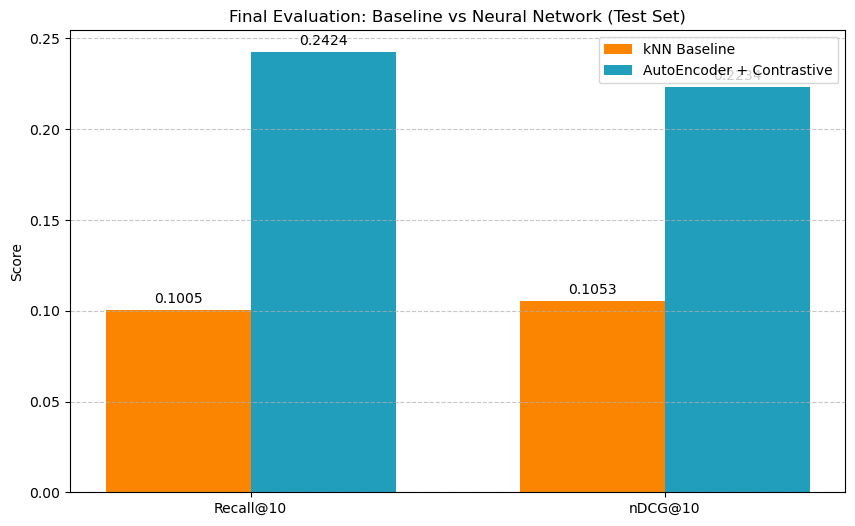

In [27]:
# Данные для графика
metrics = ['Recall@10', 'nDCG@10']
baseline_vals = [test_baseline_recall, test_baseline_ndcg]
model_vals = [test_ae_recall, test_ae_ndcg]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - width/2, baseline_vals, width, label='kNN Baseline', color='#fb8500')
rects2 = ax.bar(x + width/2, model_vals, width, label='AutoEncoder + Contrastive', color='#219ebc')

# Добавляем подписи и оформление
ax.set_ylabel('Score')
ax.set_title('Final Evaluation: Baseline vs Neural Network (Test Set)')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Добавляем значения над столбцами
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), 
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()